# 1. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


# 2. 데이터 전처리 및 매칭

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_and_preprocess(file_path):
    # (1) 데이터 로드
    df = pd.read_csv(file_path, low_memory=False)

    # (2) 기본 전처리
    df['계약일자'] = pd.to_datetime(df['계약일자'], errors='coerce')
    df['Residual'] = df['Residual'].fillna(0)

    # (3) 중복 제거
    # PNU, 계약일, 보증금, 층수가 모두 같으면 중복으로 간주
    initial_len = len(df)
    df = df.drop_duplicates(subset=['PNU', '계약일자', '보증금(만원)', '층'])
    print(f"   - 중복 데이터 제거: {initial_len - len(df)}건 삭제됨")

    # (4) 2023년 전세/월세 데이터 추출
    df_lease = df[
        (df['계약일자'] >= '2023-01-01') &
        (df['계약일자'] <= '2023-12-31') &
        (df['전월세구분'].isin(['전세', '월세'])) &
        (df['보증금(만원)'] > 0)
    ].copy()

    # (5) 이상치 필터링 (LTV 150% 이상 제거)
    df_lease['Temp_LTV'] = df_lease['보증금(만원)'] / df_lease['Predicted_Price']
    normal_lease = df_lease[df_lease['Temp_LTV'] <= 1.5].copy()
    print(f"   - 이상치(LTV > 150%) 제거: {len(df_lease) - len(normal_lease)}건 삭제됨")

    # (6) 2024년 6월 이후 매매 데이터 추출
    df_sale = df[
        (df['계약일자'] >= '2024-06-01') &
        (df['거래금액(만원)'].notnull())
    ].copy()

    # (7) 데이터 매칭 (과거 전세 -> 미래 매매)
    merged = pd.merge(
        normal_lease[['PNU', '계약일자', '보증금(만원)', 'Predicted_Price', '계약기간_일수', '기준금리(연%)']],
        df_sale[['PNU', '계약일자', '거래금액(만원)']],
        on='PNU', suffixes=('_lease', '_sale')
    )

    # (8) 시차 필터링 (1년 이상 경과한 건만)
    merged['Time_Gap_Days'] = (merged['계약일자_sale'] - merged['계약일자_lease']).dt.days
    merged = merged[merged['Time_Gap_Days'] >= 365]

    # (9) 계약기간(년) 계산
    merged['T_years'] = merged['계약기간_일수'].fillna(730) / 365.0

    print(f"최종 검증용 데이터 쌍: {len(merged)}건")
    return merged

file_path = '/content/drive/MyDrive/전세사기 공모전/data/MD2_input_predicted_located_filled.csv'
merged_df = load_and_preprocess(file_path)

   - 중복 데이터 제거: 1486건 삭제됨
   - 이상치(LTV > 150%) 제거: 514건 삭제됨
최종 검증용 데이터 쌍: 7306건


# 3. Track B 모델 클래스 정의

In [4]:
class FinancialRiskService_Backtest:
    def __init__(self, mu_hist=-0.007366, sigma=0.313, beta=-0.0258, N=2000):
        """
        [Track B 파라미터 설정]
        - mu_hist: 과거 평균 상승률 (보수적 접근)
        - sigma: 시장 변동성
        - beta: 금리 민감도 계수
        - N: 몬테카를로 시뮬레이션 횟수
        """
        self.mu_hist = mu_hist
        self.sigma = sigma
        self.beta = beta
        self.alpha = 0.7544  # 경매 낙찰가율
        self.N = N
        self.HISTORICAL_AVG_RATE = 4.74 # 과거 평균 금리 기준

    def calculate_pd_batch(self, V0_array, B_array, T_array, rate_array):
        """
        대용량 데이터 처리를 위한 벡터화(Vectorized)된 PD 계산 함수
        """
        # 1. Mu(상승률) 보정: 당시 금리 반영
        rate_diff = rate_array - self.HISTORICAL_AVG_RATE
        mu_adj = self.mu_hist + (self.beta * rate_diff)

        # 2. GBM 시뮬레이션 (Broadcasting)
        # Shape: (데이터개수, N)
        n_samples = len(V0_array)

        # Drift(추세) & Diffusion(변동성) 계산
        drift = (mu_adj[:, None] - 0.5 * self.sigma**2) * T_array[:, None]
        diffusion = self.sigma * np.sqrt(T_array[:, None]) * np.random.normal(0, 1, (n_samples, self.N))

        # 2년 뒤 집값 예측 (V_T)
        V_T = V0_array[:, None] * np.exp(drift + diffusion)

        # 3. 손실 발생 여부 (Recovery 고려)
        recovery = self.alpha * V_T
        loss = np.maximum(B_array[:, None] - recovery, 0)

        # 4. PD 산출 (평균)
        pd_values = np.mean(loss > 0, axis=1)

        return pd_values

# 4. 시뮬레이션 실행

In [5]:
# 4. 시뮬레이션 실행

# 모델 인스턴스 생성
risk_model = FinancialRiskService_Backtest(N=10000)

# 입력 변수 추출 (Numpy 배열로 변환)
V0 = merged_df['Predicted_Price'].values
B = merged_df['보증금(만원)'].values
T = merged_df['T_years'].values
rates = merged_df['기준금리(연%)'].fillna(3.5).values

# 일괄 계산 (Batch Processing)
merged_df['TrackB_PD'] = risk_model.calculate_pd_batch(V0, B, T, rates)

print(f"평균 PD: {merged_df['TrackB_PD'].mean()*100:.2f}%")

평균 PD: 41.97%


# 5. 최종 검증 및 성과 리포트

=== [1] 통계적 유의성 검증 (Logistic Regression) ===
 - P-value: 9.4139e-171
결과: P-value < 0.05 (통계적으로 매우 유의미함)

=== [2] 모델 변별력 검증 (ROC AUC) ===
 - AUC Score: 0.8000

=== [3] 사고 방어율 비교 (Track A vs Track B) ===
 - 분석 대상(실제 깡통전세 사고): 940건
  Track A 단독 방어: 169건 (방어율 18.0%)
  Track B 추가 방어: 771건 (기여도 +82.0%p)
  최종 방어율 (합계): 100.0%


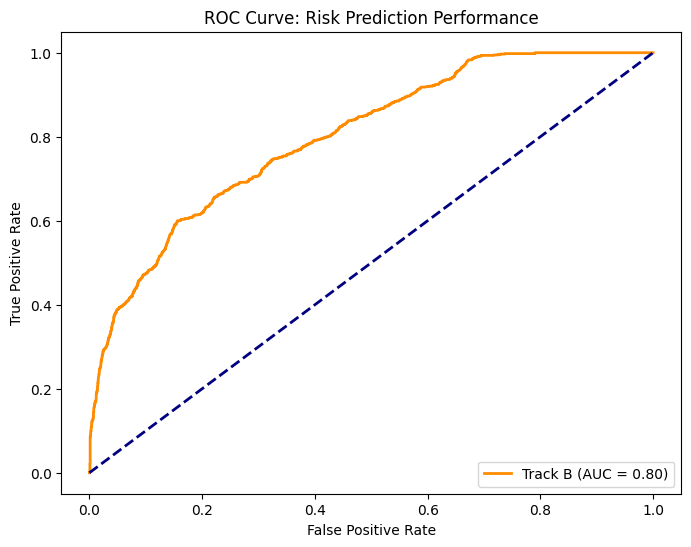

In [6]:
#로지스틱 회귀로 검증

# (1) 정답지 생성 (실제 사고 여부)
# 보증금이 나중에 팔린 매매가보다 비싸면 '사고(1)', 아니면 '정상(0)'
merged_df['Y_Actual_Default'] = (merged_df['보증금(만원)'] > merged_df['거래금액(만원)']).astype(int)

# (2) 로지스틱 회귀분석 (통계적 유의성 검증)
X = sm.add_constant(merged_df['TrackB_PD'])
y = merged_df['Y_Actual_Default']
logit_model = sm.Logit(y, X).fit(disp=0)

print(f"=== [1] 통계적 유의성 검증 (Logistic Regression) ===")
print(f" - P-value: {logit_model.pvalues['TrackB_PD']:.4e}")
if logit_model.pvalues['TrackB_PD'] < 0.05:
    print("결과: P-value < 0.05 (통계적으로 매우 유의미함)")
else:
    print("결과: 유의미하지 않음")

# (3) ROC AUC Score
fpr, tpr, thresholds = roc_curve(y, merged_df['TrackB_PD'])
roc_auc = auc(fpr, tpr)
print(f"\n=== [2] 모델 변별력 검증 (ROC AUC) ===")
print(f" - AUC Score: {roc_auc:.4f}")

# (4) Track A vs Track B 방어율 비교 (핵심 성과)
# Track A 경고: 보증금 > 적정가 (LTV > 100%)
# Track B 경고: PD >= 5%
merged_df['TrackA_Warning'] = merged_df['보증금(만원)'] > merged_df['Predicted_Price']
merged_df['TrackB_Warning'] = merged_df['TrackB_PD'] >= 0.05

# 실제 사고가 난 건들만 추출
default_cases = merged_df[merged_df['Y_Actual_Default'] == 1]
total_defaults = len(default_cases)

count_A = len(default_cases[default_cases['TrackA_Warning'] == True])
count_B_only = len(default_cases[(default_cases['TrackA_Warning'] == False) & (default_cases['TrackB_Warning'] == True)])

print(f"\n=== [3] 사고 방어율 비교 (Track A vs Track B) ===")
print(f" - 분석 대상(실제 깡통전세 사고): {total_defaults}건")
print(f"  Track A 단독 방어: {count_A}건 (방어율 {count_A/total_defaults*100:.1f}%)")
print(f"  Track B 추가 방어: {count_B_only}건 (기여도 +{count_B_only/total_defaults*100:.1f}%p)")
print(f"  최종 방어율 (합계): {(count_A + count_B_only)/total_defaults*100:.1f}%")

# (5) ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Track B (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Risk Prediction Performance')
plt.legend(loc="lower right")
plt.show()


=== [4] 모델 신뢰도 정밀 점검 (Calibration) ===
        Risk_Grade  Total_Count  Actual_Default_Count  Actual_Default_Rate
0       Safe (<5%)          483                     0             0.000000
1      Low (5-20%)          735                     0             0.000000
2  Medium (20-50%)         3323                   240             0.072224
3    High (50-80%)         2596                   575             0.221495
4  Critical (>80%)          169                   125             0.739645


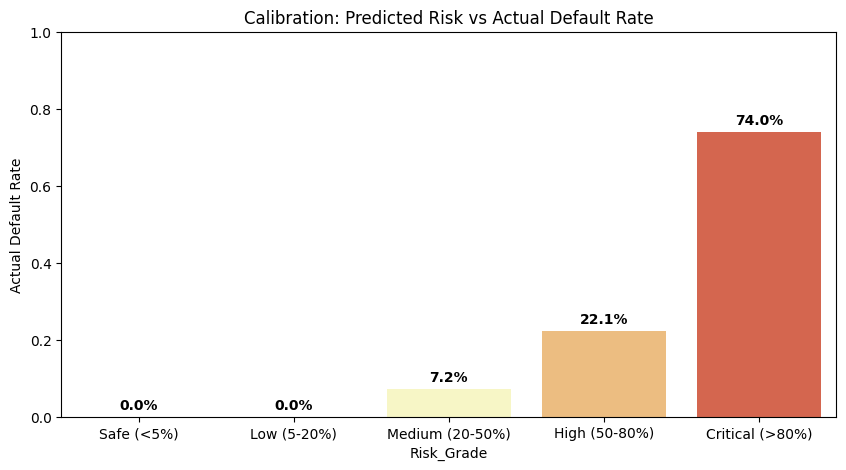

In [7]:
# [추가 1] Calibration 분석 (모델의 확률 vs 실제 사고율)
print("\n=== [4] 모델 신뢰도 정밀 점검 (Calibration) ===")

# PD를 5개 구간으로 나눔 (안전 ~ 초위험)
bins = [0, 0.05, 0.20, 0.50, 0.80, 1.01]
labels = ['Safe (<5%)', 'Low (5-20%)', 'Medium (20-50%)', 'High (50-80%)', 'Critical (>80%)']
merged_df['Risk_Grade'] = pd.cut(merged_df['TrackB_PD'], bins=bins, labels=labels, right=False)

# 구간별 실제 사고율 계산
calib_df = merged_df.groupby('Risk_Grade', observed=False).agg(
    Total_Count=('PNU', 'count'),
    Actual_Default_Count=('Y_Actual_Default', 'sum'),
    Actual_Default_Rate=('Y_Actual_Default', 'mean')
).reset_index()

print(calib_df)

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='Risk_Grade', y='Actual_Default_Rate', data=calib_df, palette='RdYlGn_r')
plt.title('Calibration: Predicted Risk vs Actual Default Rate')
plt.ylabel('Actual Default Rate')
plt.ylim(0, 1.0)
for index, row in calib_df.iterrows():
    plt.text(index, row.Actual_Default_Rate + 0.02, f"{row.Actual_Default_Rate*100:.1f}%", ha='center', fontweight='bold')
plt.show()


In [8]:
# 안전 그룹(Safe Zone) 검증
print("=== [5] '안전 등급' 유효성 검증 ===")

safe_group = merged_df[merged_df['TrackB_PD'] < 0.05]
safe_total = len(safe_group)
safe_accidents = safe_group['Y_Actual_Default'].sum()

print(f"1. 모델이 '안전하다(PD < 5%)'고 분류한 건수: {safe_total}건")
print(f"2. 그 중 실제 사고 발생 건수: {safe_accidents}건")
print(f"3. 안전 등급 생존율: {(1 - safe_accidents/safe_total)*100:.2f}%")



=== [5] '안전 등급' 유효성 검증 ===
1. 모델이 '안전하다(PD < 5%)'고 분류한 건수: 483건
2. 그 중 실제 사고 발생 건수: 0건
3. 안전 등급 생존율: 100.00%


In [9]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def choose_threshold_by_roc(
    y_true: np.ndarray,
    y_score: np.ndarray,
    method: str = "youden",      # "youden" | "fpr_cap" | "tpr_target"
    fpr_cap: float = 0.10,       # method="fpr_cap"일 때
    tpr_target: float = 0.80     # method="tpr_target"일 때
):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    mask = np.isfinite(y_true) & np.isfinite(y_score)
    y_true = y_true[mask]
    y_score = y_score[mask]

    fpr, tpr, thr = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    if method == "youden":
        j = tpr - fpr
        i = int(np.argmax(j))
        th = float(thr[i])

    elif method == "fpr_cap":
        ok = fpr <= fpr_cap
        if not np.any(ok):
            i = int(np.argmin(fpr))  # cap 만족 못하면 FPR 최소
        else:
            i_ok = np.where(ok)[0]
            i = int(i_ok[np.argmax(tpr[ok])])  # cap 내에서 TPR 최대
        th = float(thr[i])

    elif method == "tpr_target":
        ok = tpr >= tpr_target
        if not np.any(ok):
            i = int(np.argmax(tpr))  # target 못 맞추면 TPR 최대
        else:
            i_ok = np.where(ok)[0]
            i = int(i_ok[np.argmin(fpr[ok])])  # target 이상 중 FPR 최소
        th = float(thr[i])

    else:
        raise ValueError("method must be one of: 'youden', 'fpr_cap', 'tpr_target'")

    # chosen threshold에서의 TPR/FPR
    # thr는 보통 내림차순이라 interp 위해 뒤집음
    tpr_at = float(np.interp(th, thr[::-1], tpr[::-1]))
    fpr_at = float(np.interp(th, thr[::-1], fpr[::-1]))

    summary = {
        "AUC": float(auc),
        "threshold": float(th),
        "TPR_at_th": tpr_at,
        "FPR_at_th": fpr_at,
        "pos_rate": float(y_true.mean()),
        "n": int(len(y_true)),
    }
    return th, summary

In [10]:
# ===============================
# Track B 고/저위험 임계값 산출
# ===============================

df_backtest = pd.read_csv("/content/drive/MyDrive/전세사기 공모전/data/val data.csv")

y_true  = df_backtest["Y_Actual_Default"].values
y_score = df_backtest["TrackB_PD"].values

threshold, summary = choose_threshold_by_roc(
    y_true,
    y_score,
    method="youden"
)

print("\n[Track B PD 임계값 산출]")
print("PD threshold:", threshold)
print("AUC:", summary["AUC"])
print("FPR@th:", summary["FPR_at_th"])
print("TPR@th:", summary["TPR_at_th"])


# ===============================
# Track B 고/저위험 분류
# ===============================
df_backtest["TrackB_risk"] = np.where(
    df_backtest["TrackB_PD"] >= threshold,
    "고위험",
    "저위험"
)

print("\n[Track B 위험도 분포]")
print(df_backtest["TrackB_risk"].value_counts())


[Track B PD 임계값 산출]
PD threshold: 0.5112
AUC: 0.7993672335077975
FPR@th: 0.23782595036129436
TPR@th: 0.676595744680851

[Track B 위험도 분포]
TrackB_risk
저위험    5156
고위험    2150
Name: count, dtype: int64


In [15]:
# ===============================
# Track B 고/저위험 임계값 산출 (그리드서치 기반)
# ===============================
import numpy as np

# 그리드서치: 실루엣 점수 기반으로 (t_low, t_high) 탐색
from sklearn.metrics import silhouette_score

def grid_search_thresholds(vals, n_grid=50, min_group_pct=0.01):
    vals = np.asarray(vals).reshape(-1, 1)
    if vals.size == 0:
        raise ValueError('데이터가 비어 있습니다.')

    v_min, v_max = vals.min(), vals.max()
    lows = np.linspace(v_min, v_max, n_grid)
    highs = np.linspace(v_min, v_max, n_grid)

    best = {'score': -1}
    n = len(vals)
    min_count = max(5, int(min_group_pct * n))

    for t_low in lows:
        for t_high in highs:
            if t_high <= t_low:
                continue

            labels = np.where(vals < t_low, 0, np.where(vals >= t_high, 2, 1))

            unique, counts = np.unique(labels, return_counts=True)
            if len(counts) < 3:
                continue
            if any(counts < min_count):
                continue

            try:
                s = silhouette_score(vals, labels.ravel())
            except Exception:
                continue

            if s > best['score']:
                best = {'score': float(s), 't_low': float(t_low), 't_high': float(t_high), 'labels': labels.copy()}
    return best

# 데이터 준비
# (기존 df_backtest 로딩이 위에 있으므로 재사용)
vals = df_backtest['TrackB_PD'].dropna().values

# 그리드서치 실행
best = grid_search_thresholds(vals, n_grid=20, min_group_pct=0.01)

if best['score'] < 0:
    # fallback: 기존 ROC 기반 선택 사용
    threshold, summary = choose_threshold_by_roc(
        df_backtest['Y_Actual_Default'].values,
        df_backtest['TrackB_PD'].values,
        method='youden'
    )
    print('\n[Grid search failed — fallback to ROC Youden]')
    print(f'Chosen threshold (ROC Youden): {threshold:.4f}')
else:
    t_low, t_high = best['t_low'], best['t_high']
    threshold = t_high  # 고위험 판정 임계값으로 t_high 사용
    print('\n[Grid search thresholds found]')
    print(f"- Silhouette Score : {best['score']:.4f}")
    print(f"- t_low            : {t_low:.6f}")
    print(f"- t_high           : {t_high:.6f}")

# 고/저위험 분류
df_backtest['TrackB_risk'] = np.where(
    df_backtest['TrackB_PD'] >= threshold,
    '고위험',
    '저위험'
)

print('\n[Track B 위험도 분포]')
print(df_backtest['TrackB_risk'].value_counts())

# 요약 출력
print('\n[사용된 임계값 요약]')
print(f'High threshold (t_high) = {threshold:.6f}')
if 'summary' in locals():
    print(f"ROC AUC (fallback) = {summary['AUC']:.4f}")




[Grid search thresholds found]
- Silhouette Score : 0.5607
- t_low            : 0.210021
- t_high           : 0.472547

[Track B 위험도 분포]
TrackB_risk
저위험    4486
고위험    2820
Name: count, dtype: int64

[사용된 임계값 요약]
High threshold (t_high) = 0.472547
ROC AUC (fallback) = 0.7994
